### References
- https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- https://github.com/soumith/ganhacks

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2 as T
import torchvision.utils as vutils
import random
from torch.utils.data.dataset import random_split
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.transforms.functional import convert_image_dtype

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64
NZ = 256        # Размер векторра шума z
NGF = 32        # Размер модификатора каналов в генераторе
NDF = 32        # Размер модификатора каналов в дискриминаторе
NC = 3          # Количество каналов в изображении
BETA_1 = 0.5    # B1 коэффициент оптимизатора
CLASS_N = 11    # Количество классов в датасете

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input: NZ
            nn.ConvTranspose2d(NZ, NGF * 12, 4, 1, 0, bias=False),
            nn.BatchNorm2d(NGF * 12),
            nn.ReLU(True),
            # ngf*12 x 4 x 4 
            nn.ConvTranspose2d(NGF * 12, NGF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 8),
            nn.ReLU(True),
            # ngf*8 x 8 x 8 
            nn.ConvTranspose2d(NGF * 8, NGF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 4),
            nn.ReLU(True),
            # ngf*4 x 16 x 16
            nn.ConvTranspose2d(NGF * 4, NGF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF * 2),
            nn.ReLU(True),
            # ngf*2 x 32 x 32
            nn.ConvTranspose2d(NGF * 2, NGF , 4, 2, 1, bias=False),
            nn.BatchNorm2d(NGF),
            nn.ReLU(True),
            # ngf x 64 x 64
            nn.ConvTranspose2d(NGF, NC, 4, 2, 1, bias=False),
            nn.Tanh(),
            # nc x 128 x 128
        )

    def forward(self, x, rnd=0.005):
        x = self.main(x)
        noise = (rnd**0.5)*torch.randn(x.shape, device=DEVICE).detach()
        return x + noise

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input: nc x 128 x 128
            nn.Conv2d(NC, NDF, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf x 64 x 64
            nn.Conv2d(NDF, NDF * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*2 x 32 x 32
            nn.Conv2d(NDF * 2, NDF * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*4 x 16 x 16
            nn.Conv2d(NDF * 4, NDF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*8 x 8 x 8
            nn.Conv2d(NDF * 8, NDF * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # ndf*8 x 4 x 4
        )

        self.image_classification = nn.Sequential(
            nn.Conv2d(NDF * 8, CLASS_N, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.fake_classification = nn.Sequential(
            nn.Conv2d(NDF * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        fake = self.fake_classification(x)
        label = self.image_classification(x)
        return fake, label

In [5]:
def train(models, data_loader: DataLoader, optimizers: tuple, loss_fn, class_loss_fn, rnd=0.005):
    D, G = models
    G.train()
    D.train()

    d_optim, g_optim = optimizers
    train_d_loss, train_g_loss = 0, 0

    for real_img, class_label in data_loader:
        real_img, class_label = real_img.to(DEVICE), class_label.to(DEVICE)
        batch_size = real_img.size(0)

        fake_img = G(torch.randn(batch_size, NZ, 1, 1, device=DEVICE), rnd)

        # добавляем шум в входные данные
        real_img = real_img + (rnd**0.5)*torch.randn(real_img.shape, device=DEVICE).detach()
       
        # тренируем дискриминатор
        d_optim.zero_grad()
        # реальные изображения
        true_outs, label = D(real_img)
        d_real_loss = loss_fn(true_outs, torch.ones_like(true_outs, device=DEVICE).uniform_(0.9, 0.9))
        d_real_loss = d_real_loss + class_loss_fn(label.squeeze(2, 3), class_label)
        d_real_loss.backward()

        # фейковые изображения
        fake_outs, _ = D(fake_img.detach())
        d_fake_img_loss = loss_fn(fake_outs, torch.zeros_like(fake_outs, device=DEVICE))
        d_fake_img_loss.backward()  
        d_optim.step()
        
        # тренируем генератор
        g_optim.zero_grad()
        fake_outs_, _ = D(fake_img)
        g_loss = loss_fn(fake_outs_, torch.ones_like(fake_outs_, device=DEVICE).uniform_(0.9, 0.9))
        g_loss.backward()
        g_optim.step()

        train_d_loss += (d_real_loss + d_fake_img_loss).item()
        train_g_loss += g_loss.item()

    train_g_loss /= len(data_loader)
    train_d_loss /= len(data_loader)

    return train_d_loss, train_g_loss

In [6]:
@torch.no_grad()
def rescale(tensor):
    tensor -= tensor.min() 
    tensor /= tensor.max() 
    return tensor

@torch.no_grad()
def eval(model, data_loader, fid):
    G = model
    G.to(DEVICE)
    G.eval()

    for real_img, _ in data_loader:
        real_img = real_img.to(DEVICE)
        batch_size = real_img.size(0)
        fake_img = G(torch.randn(batch_size, NZ, 1, 1, device=DEVICE))

        fid.update(convert_image_dtype(real_img.clamp(0, 1), torch.uint8), real=True)
        fid.update(convert_image_dtype(fake_img.clamp(0, 1), torch.uint8), real=False)

    score = fid.compute()
    fid.reset()
    return score

In [7]:
image_dataset = ImageFolder(
    root='planets',
    transform=T.Compose([
        T.Resize(128),
        T.ToTensor()
    ]))

train_data , eval_data = random_split(image_dataset, (int(len(image_dataset) * 0.9), len(image_dataset) - int(len(image_dataset) * 0.9)))
data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
eval_data_loader = torch.utils.data.DataLoader(eval_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
G = Generator()
D = Discriminator()

G.apply(weights_init)
D.apply(weights_init)

G.to(DEVICE)
D.to(DEVICE)

g_optim = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(BETA_1, 0.999))
d_optim = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(BETA_1, 0.999))
loss_fn = nn.BCELoss()
class_loss_fn = nn.CrossEntropyLoss()
fid = FrechetInceptionDistance(feature=2048, reset_real_features=False).to(DEVICE)

In [9]:
fix_noise = torch.randn(16, NZ, 1, 1, device=DEVICE)


def plot_examples(title=None):
    G.eval()
    D.eval()

    plt.figure(figsize=(10, 4))
    images = G(fix_noise)

    plt.imshow(np.transpose(vutils.make_grid(images.clamp(0, 1).cpu(), padding=5, normalize=True), (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

In [10]:
def change_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

epoch:1, d loss:2.592782735824585, g loss:3.6782560900944037, fid:297.7055969238281
epoch:2, d loss:2.250175109723719, g loss:3.690397518437083, fid:303.7372741699219
epoch:3, d loss:2.4255088887563567, g loss:4.230914136258567, fid:269.1699523925781
epoch:4, d loss:2.3862507285141366, g loss:3.107354758716211, fid:297.1304931640625
epoch:5, d loss:2.409298524623964, g loss:2.5956760121554865, fid:297.99676513671875
epoch:6, d loss:2.349491462474916, g loss:2.6165153602274454, fid:288.08837890625
epoch:7, d loss:2.5072971204432046, g loss:2.503221026281031, fid:298.14324951171875
epoch:8, d loss:2.437952332380341, g loss:2.29292563403525, fid:281.9899597167969
epoch:9, d loss:2.342360409294687, g loss:2.3886623411643795, fid:282.8622131347656
epoch:10, d loss:2.289565161960881, g loss:2.3780165009382292, fid:247.3205108642578
epoch:11, d loss:2.5330843983626945, g loss:2.0702816567769866, fid:290.6500549316406
epoch:12, d loss:2.484773775426353, g loss:1.9716163321239193, fid:251.35655

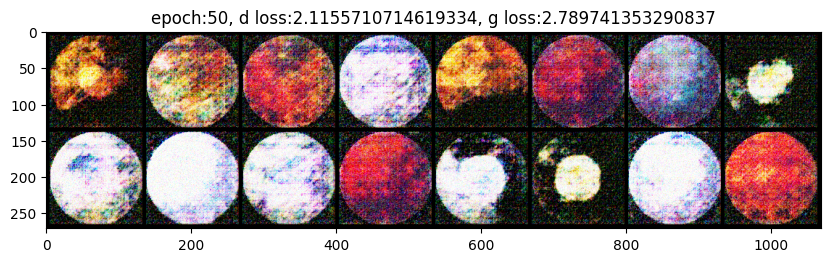

epoch:51, d loss:2.055124166535168, g loss:2.829330612973469, fid:219.85073852539062
epoch:52, d loss:2.2980326501334587, g loss:2.671874595851433, fid:228.28977966308594
epoch:53, d loss:2.2959397013594462, g loss:2.4254301495668367, fid:230.00840759277344
epoch:54, d loss:2.273720168485874, g loss:2.347959379597408, fid:216.75250244140625
epoch:55, d loss:2.289090374620949, g loss:2.58244131832588, fid:232.39987182617188
epoch:56, d loss:2.22730741268251, g loss:2.550045897321003, fid:225.8776397705078
epoch:57, d loss:2.181242468880444, g loss:2.639425748732032, fid:235.73085021972656
epoch:58, d loss:2.0770611792075924, g loss:2.746490536666498, fid:220.25564575195312
epoch:59, d loss:2.1061146491911353, g loss:2.8724494910821683, fid:221.27569580078125
epoch:60, d loss:2.265976731370135, g loss:2.5555068487074317, fid:217.72201538085938
epoch:61, d loss:2.3175428466099066, g loss:2.458347493555488, fid:231.876220703125
epoch:62, d loss:2.1622379669329015, g loss:2.626277272294207,

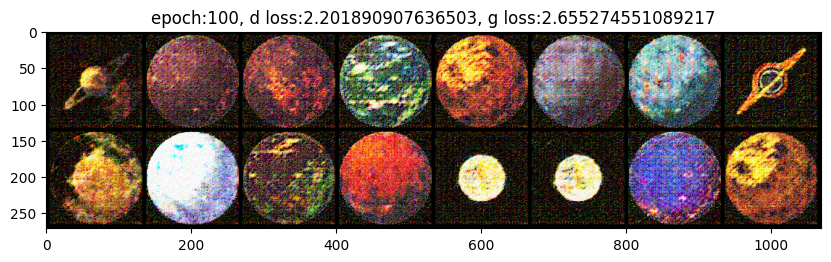

epoch:101, d loss:2.083260655403137, g loss:2.6715923024386896, fid:209.20802307128906
epoch:102, d loss:2.076475506875573, g loss:2.713160578797503, fid:208.63955688476562
epoch:103, d loss:2.145798930307714, g loss:2.7819220845292256, fid:209.7838134765625
epoch:104, d loss:2.0712268119905053, g loss:2.6250954401202318, fid:206.3577423095703
epoch:105, d loss:2.0802815076781482, g loss:2.6726229365279033, fid:205.12460327148438
epoch:106, d loss:2.0483905803866502, g loss:2.8334432665894673, fid:207.53997802734375
epoch:107, d loss:2.0239085104407333, g loss:2.916385086571298, fid:196.45538330078125
epoch:108, d loss:2.0910476736906096, g loss:2.8454544195314733, fid:205.18927001953125
epoch:109, d loss:2.118023351925175, g loss:2.6290752335292535, fid:195.09832763671875
epoch:110, d loss:2.023534777687817, g loss:2.982098434029556, fid:205.20985412597656
epoch:111, d loss:2.1076498496823195, g loss:2.7412367971932015, fid:209.08889770507812
epoch:112, d loss:2.071203580716761, g los

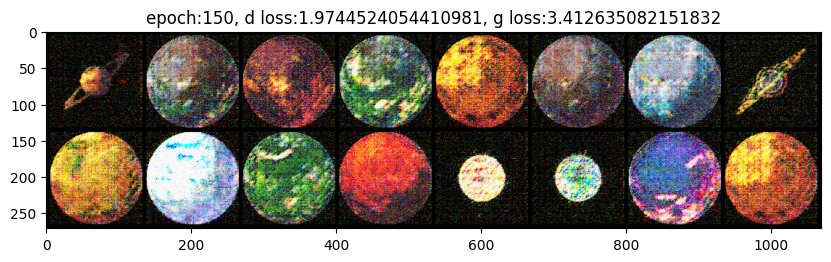

epoch:151, d loss:2.0187991624925195, g loss:3.62047069247176, fid:208.32778930664062
epoch:152, d loss:2.06366130200828, g loss:3.114641532665346, fid:209.8616180419922
epoch:153, d loss:1.955235481262207, g loss:3.576403885352902, fid:212.69393920898438
epoch:154, d loss:1.9981311036319267, g loss:3.6216880344763034, fid:200.46376037597656
epoch:155, d loss:1.9732269804652145, g loss:3.607358548699356, fid:195.51698303222656
epoch:156, d loss:1.989173982201553, g loss:3.5465823673620456, fid:202.6526336669922
epoch:157, d loss:2.134757771724608, g loss:3.49139354868633, fid:202.82244873046875
epoch:158, d loss:2.2818117868609544, g loss:3.278362131700283, fid:201.2417755126953
epoch:159, d loss:2.0777236862880426, g loss:3.0643377507605205, fid:190.90130615234375
epoch:160, d loss:1.983686700099852, g loss:3.415157806582567, fid:190.531494140625
epoch:161, d loss:1.9671379037019683, g loss:3.770899923836313, fid:197.69775390625
epoch:162, d loss:2.019514444397717, g loss:3.2874429778

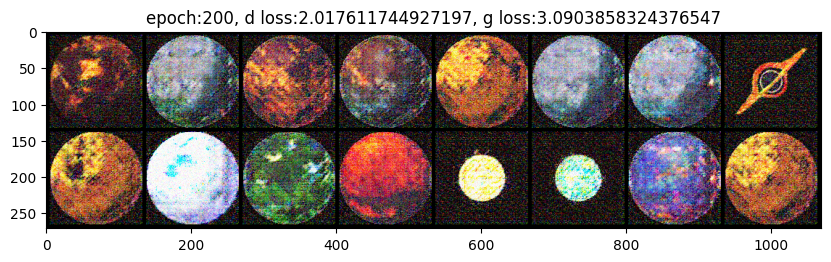

epoch:201, d loss:1.9550848065353021, g loss:3.5078963651889707, fid:210.14486694335938
epoch:202, d loss:1.947418500737446, g loss:3.62784139121451, fid:213.81797790527344
epoch:203, d loss:1.9456678396318017, g loss:3.5117391958469297, fid:213.27587890625
epoch:204, d loss:1.9482528988907977, g loss:3.5818125649196344, fid:214.6254119873047
epoch:205, d loss:1.9305650722689744, g loss:3.921477934209312, fid:216.10546875
epoch:206, d loss:1.9446404183783181, g loss:3.765713194521462, fid:215.36306762695312
epoch:207, d loss:1.9549511903669776, g loss:3.715510368347168, fid:215.3271484375
epoch:208, d loss:1.9544603853690914, g loss:3.6592077685565485, fid:213.4058074951172
epoch:209, d loss:1.9496968344944279, g loss:3.641382484901242, fid:209.48023986816406
epoch:210, d loss:1.923964055573068, g loss:3.7658463978185885, fid:212.0542755126953
epoch:211, d loss:1.9269777158411538, g loss:3.9047651639798793, fid:205.73744201660156
epoch:212, d loss:1.9258704563466513, g loss:3.917944806

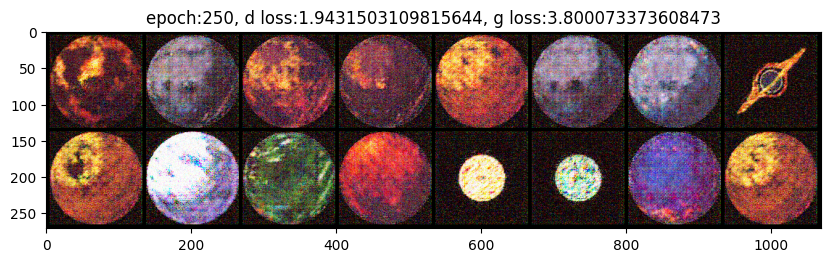

epoch:251, d loss:1.9156863049763004, g loss:4.11720609664917, fid:210.1195068359375
epoch:252, d loss:1.9152454515782797, g loss:4.246917224511868, fid:205.82427978515625
epoch:253, d loss:1.9037405194305792, g loss:4.427858835313378, fid:207.8738250732422
epoch:254, d loss:1.9081144042131377, g loss:4.448052429571384, fid:202.6621551513672
epoch:255, d loss:1.9299801006549742, g loss:4.22426879115221, fid:198.4188232421875
epoch:256, d loss:1.9354469020192215, g loss:3.9174142872414937, fid:195.830322265625
epoch:257, d loss:1.947288594594816, g loss:3.854780435562134, fid:188.93954467773438
epoch:258, d loss:1.9248107410058743, g loss:4.06161568804485, fid:193.20530700683594
epoch:259, d loss:1.9372993765807733, g loss:4.112598488970501, fid:192.85975646972656
epoch:260, d loss:1.920863497547987, g loss:4.366273315941415, fid:195.7464599609375
epoch:261, d loss:1.95385951821397, g loss:4.227187005484977, fid:200.83775329589844
epoch:262, d loss:1.9509756477867686, g loss:3.904905662

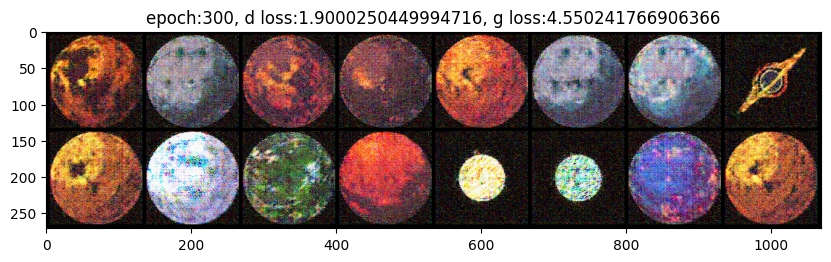

epoch:301, d loss:1.9317016659713373, g loss:4.258655926076377, fid:208.41989135742188
epoch:302, d loss:1.9211665537299178, g loss:4.3406385154258915, fid:208.84112548828125
epoch:303, d loss:1.9049142453728654, g loss:4.318348599643242, fid:204.8446044921875
epoch:304, d loss:1.9012905330192753, g loss:4.42353346289658, fid:203.60543823242188
epoch:305, d loss:1.911684332824335, g loss:4.522129657791882, fid:204.1784210205078
epoch:306, d loss:1.9033362080411214, g loss:4.320657352121865, fid:202.15150451660156
epoch:307, d loss:1.8928670708726092, g loss:4.8586982808462, fid:203.21279907226562
epoch:308, d loss:1.9247740332673235, g loss:4.859863339400873, fid:204.88282775878906
epoch:309, d loss:1.9311239079731266, g loss:3.870693852261799, fid:208.79733276367188
epoch:310, d loss:1.9112713075265653, g loss:4.513096786126858, fid:210.10507202148438
epoch:311, d loss:1.9426718078008511, g loss:4.066393195129022, fid:204.54295349121094
epoch:312, d loss:1.9247856401815646, g loss:4.4

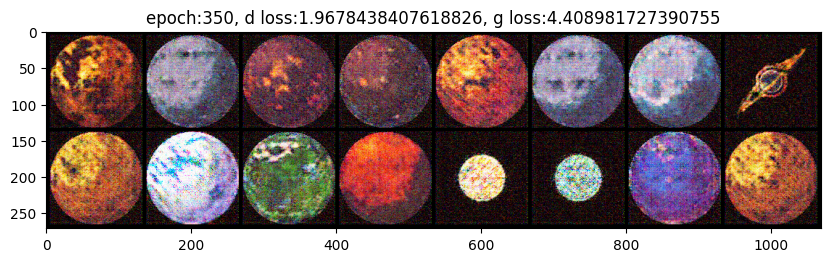

epoch:351, d loss:1.9983363703983585, g loss:3.9479816250684783, fid:201.06378173828125
epoch:352, d loss:1.933067057190872, g loss:4.049519818003585, fid:202.9854736328125
epoch:353, d loss:1.9312921704315558, g loss:4.469823976842369, fid:199.55201721191406
epoch:354, d loss:1.9276617678200327, g loss:4.275600584541879, fid:199.62637329101562
epoch:355, d loss:1.912195572038976, g loss:4.566484346622374, fid:202.77322387695312
epoch:356, d loss:1.9319839215860135, g loss:4.581329025873324, fid:204.01760864257812
epoch:357, d loss:1.9697522739084756, g loss:4.36541134264411, fid:203.4424591064453
epoch:358, d loss:1.9752293447168863, g loss:3.8474815822229154, fid:201.2141571044922
epoch:359, d loss:1.9204527139663696, g loss:4.054134409602096, fid:213.40684509277344
epoch:360, d loss:1.9051261268010953, g loss:4.376440594835979, fid:207.3173828125
epoch:361, d loss:1.8996859788894653, g loss:4.538927351556173, fid:208.50534057617188
epoch:362, d loss:1.9755618921140345, g loss:4.3558

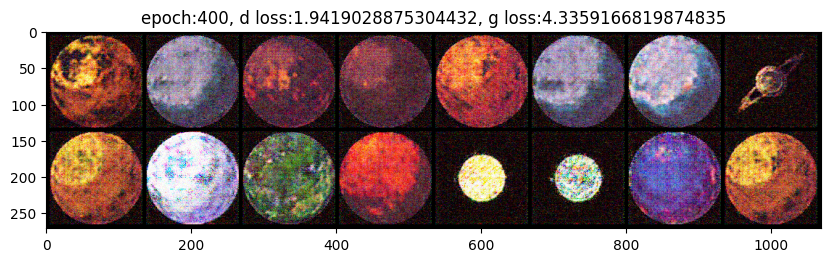

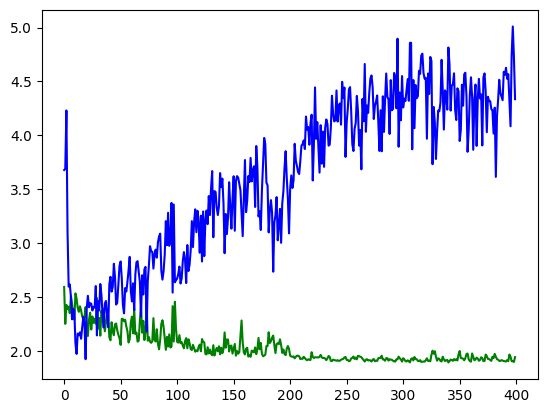

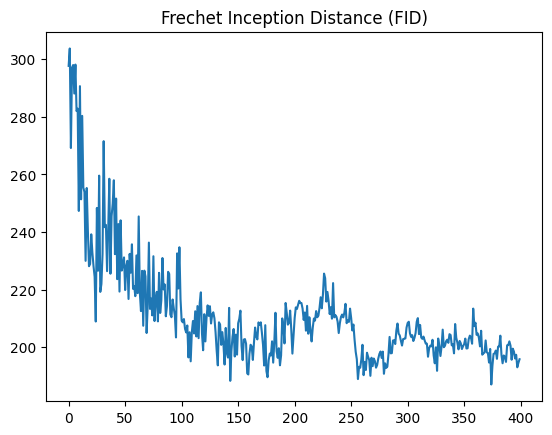

In [11]:
all_d_loss, all_g_loss, all_fid_score = [], [], []
rnd = random.uniform(0, 0.2)
for e in range(1, 401):
    if e == 100:
        change_lr(g_optim, 1e-4)
        change_lr(d_optim, 1e-4)
        rnd = random.uniform(0, 0.1)
    if e == 200:
        change_lr(g_optim, 2e-5)
        change_lr(d_optim, 2e-5)
        rnd = random.uniform(0, 0.05)

    d_loss, g_loss = train((D, G), data_loader, (d_optim, g_optim), loss_fn, class_loss_fn, rnd)
    all_d_loss.append(d_loss)
    all_g_loss.append(g_loss)

    fid_score = eval(G, eval_data_loader, fid)
    all_fid_score.append(fid_score.cpu())
    print(f'epoch:{e}, d loss:{d_loss}, g loss:{g_loss}, fid:{fid_score}')
    if e % 50 == 0:
        plot_examples(f'epoch:{e}, d loss:{d_loss}, g loss:{g_loss}')

plt.plot(all_d_loss, color='green')
plt.plot(all_g_loss, color='blue')
plt.show()

plt.plot(all_fid_score)
plt.title('Frechet Inception Distance (FID)')
plt.show()

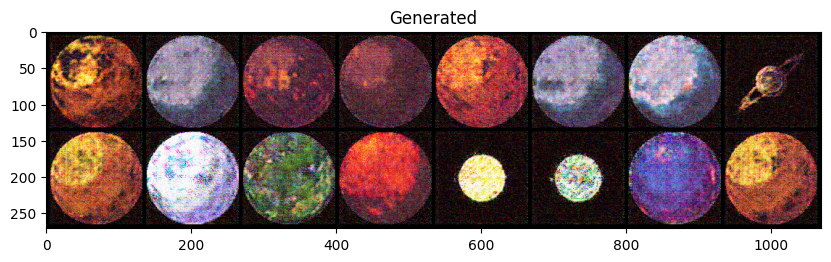

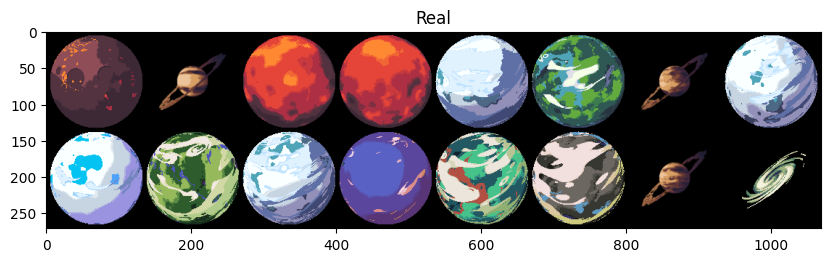

In [12]:
plot_examples('Generated')
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(vutils.make_grid(next(iter(data_loader))[0][:16], padding=5, normalize=True), (1, 2, 0)))
plt.title('Real')
plt.show()